## Import everything

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
import os
from google.colab.patches import cv2_imshow
import cv2
import dlib
import requests
from bs4 import BeautifulSoup
import sys
import imgaug as ia
from imgaug import augmenters as iaa
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

import keras
from keras.models import Model
from keras.layers import *

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=94b20149b4ccaafd1ef80d45ebaecc95241a46b71415da1fdbb8c148647e97bd
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Image Augmentation Functions (not used right now)

In [ ]:
IMG_SIZE = 128
tf.random.set_seed(1234);

img_buffer = np.empty((10030, 128, 128, 3))
def augment_images(dir):
    count = 0
    for f in os.listdir("./"+dir):
        print(f)
        img = cv2.imread(dir+"/"+f, cv2.IMREAD_COLOR)
        #cv2_imshow(img)
        img_resized = tf.image.resize(img, [128, 128])
        img_buffer[count] = img_resized
        count += 1
        for i in range(16):
            try:
                aug_img, label = augment(img, "label")
                img_buffer[count] = aug_img[:,:,:]
                count += 1
            except:
                print("\ndoesn't work\n",f)
            #cv2_imshow(aug_img.numpy() * 255)


def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)
    return image, label

def augment(image,label):
    image, label = resize_and_rescale(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.66, 1.5)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[128, 128, 3])
    image = tf.image.resize(image, [128, 128])
    #   image = tf.clip_by_value(image, 0, 1)
    return image, label


### Facial detection area (placeholder)

### Make Generator

Creates a generator which takes in some random noise and 
runs it through multiple layers to output an image. It resizes the input 
as it goes and before each resizing it runs LeakyReLU in order to help it 
converge faster as it amplifies positive values and zeros out negative 
ones. It creates artwork for the discriminator to try to determine if the 
art is real or “fake”. 

In [ ]:
def make_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(110,)))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

### Make Discriminator

make_discriminator produces a convolutional neural network image classifier.
It uses tf.keras.layers.Conv2DTranspose layers to add more filters [add here] 
The dropout is used to denoise Convolutional layers (from Tensorflow).
This discriminator will classify the generated artwork as real or “fake"
using postive numbers for real images and negative numbers for fake images.

In [ ]:
def make_discrim_two_in():
    # define two sets of inputs
    # Facial features
    featInput = Input(shape=(10,))
    # Image input
    imageInput = Input(shape=(128,128,3))
    # the first branch operates on the first input
    x = Dense(8, activation="relu")(featInput)
    x = Dense(4, activation="relu")(x)
    x = Model(inputs=featInput, outputs=x)
    # the second branch opreates on the second input
    y = Conv2D(32, 20, activation="relu")(imageInput)
    y = tf.keras.layers.LeakyReLU()(y)
    y = AveragePooling2D(2,2)(y)
    y = Conv2D(64,5,padding='same')(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = AveragePooling2D(2,2)(y)
    y = Conv2D(128,5,padding='same')(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = AveragePooling2D(2,2)(y)
    y = Flatten()(y)
    y = Dense(64)(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = Dense(32)(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = Model(inputs=imageInput, outputs=y)
    # combine the output of the two branches
    combined = concatenate([x.output, y.output])
    # apply a FC layer and then a regression prediction on the
    # combined outputs
    z = Dense(32)(combined)
    z = tf.keras.layers.LeakyReLU()(z)
    z = Dense(16)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = Dense(1)(z)
    z = Activation('sigmoid')(z)

    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=[x.input, y.input], outputs=z)
    return model

### Defining the loss functions and optimizers

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # add reconstruction loss here
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4)

### Load and prepare the dataset

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


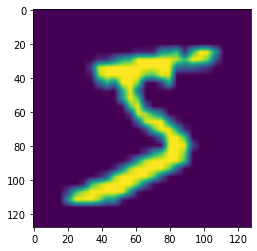

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
#img = cv2.imread(train_images[0])
img = cv2.resize(train_images[0], dsize=(128,128))
plt.imshow(img)
resized = np.empty((10000, 128, 128, 3))
for idx, ti in enumerate(train_images[:len(train_images)//6]):
    img = cv2.resize(ti, dsize=(128,128))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    resized[idx] = img


In [ ]:
# temp = np.repeat(img[:, :, np.newaxis], 3, axis=2)
# print(temp)
# print(temp.shape)
# plt.imshow(temp)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(resized).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset.__dict__

{'_batch_size': <tf.Tensor: shape=(), dtype=int64, numpy=256>,
 '_drop_remainder': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 '_graph_attr': <tensorflow.python.framework.ops.Graph at 0x7fd27d046898>,
 '_input_dataset': <ShuffleDataset shapes: (128, 128, 3), types: tf.float64>,
 '_options_attr': <tensorflow.python.data.ops.dataset_ops.Options at 0x7fd200d5dc18>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_variant_tracker', ref=<tensorflow.python.data.ops.dataset_ops._VariantTracker object at 0x7fd200d5d7f0>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'_variant_tracker': <tensorflow.python.data.ops.dataset_ops._VariantTracker at 0x7fd200d5d7f0>},
 '_self_update_uid': -1,
 '_structure': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None),
 '_variant_tensor_attr': <tf.Tensor: shap

In [ ]:
del train_images

In [ ]:
# generator = make_generator()

# noise = tf.random.normal([1, 110])
# generated_image = generator(noise, training=False)

# plt.imshow(generated_image[0, :, :, 0])

In [ ]:
# discriminator = make_discrim_two_in()
# decision = discriminator((tf.convert_to_tensor(np.zeros((1,10))), generated_image))
# print(decision)

### Save checkpoint

In [ ]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

### Define the training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# features needs to be broken into chunks of BATCH_SIZE
# @tf.function
def train_step(images, features):
    #print("in train step")
    #print(features, type(features))
    #print(images.shape)
    BATCH_SIZE = len(images)
    print("BATCH_SIZE", BATCH_SIZE)
    noise = []
    noise = tf.convert_to_tensor(np.hstack([np.random.normal(0, 1, size=(BATCH_SIZE, 100)), features]).astype(np.float32))
    noise = tf.reshape(noise, [BATCH_SIZE, 110])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
    #   print("generated_images.shape",generated_images.shape)
    #   print("images.shape",images.shape)
    #   print("features.shape",features.shape)
      real_output = discriminator((features, images), training=True)
      fake_output = discriminator((features, generated_images), training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    print("Gen loss:", gen_loss.numpy())
    print("Disc loss:", disc_loss.numpy())
    print("Disc accuracy:", tf.keras.metrics.BinaryAccuracy()(tf.round(fake_output), np.zeros(fake_output.shape)).numpy())
    cv2_imshow(generated_images[0, :, :, :].numpy() * 255.0)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # check with MNIST dataset
    # print("Gen grads:", gradients_of_generator)
    # print("Disc grads:", gradients_of_discriminator)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
# Improvements:
# 1. Increase dataset size
# 2. Add batch normalization -> nope. Read paper on weight normalization
# 3. Add loss functions to GAN
# 4. Increase size of input latent vector for Generator

generator = make_generator()
discriminator = make_discrim_two_in()

# creation of random noise plus some number of conditional variables
noise = tf.convert_to_tensor(np.concatenate([np.random.normal(0, 1, 100), np.array([0,0,0,0,0,0,0,0,0,0])], axis=None).astype(np.float32))
noise = tf.reshape(noise, [1, 110])

# running the generator with no training
generated_image = generator(noise, training=False)

print(generated_image.shape)

batch_size = 256

def train(imgdataset, featdataset, epochs):
    for epoch in range(epochs):
        print("\nEpoch:", epoch)
        GPUs = GPU.getGPUs()
        gpu = GPUs[0]
        def printm():
            process = psutil.Process(os.getpid())
            print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
            print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
        if epoch % 10 == 0:
            printm()
        count = 0
        for image_batch in imgdataset:
            #print("here",image_batch.shape)
            train_step(image_batch, featdataset[count:min(count + 256, 10000)])
            count += 256
        # Produce images for the GIF as we go
        # display.clear_output(wait=True)
        # generate_and_save_images(generator,epoch + 1,seed)
        # for i in range(0, int(imgdataset.shape[0]), batch_size):
        # print("Batch", i, "from", i, "to", i + batch_size)
        # train_step(imgdataset[i:min(i+batch_size, imgdataset.shape[0] - 1),:,:,:], featdataset[i:min(i+batch_size, imgdataset.shape[0] - 1),:])

# feats = tf.convert_to_tensor()

(1, 128, 128, 3)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# @tf.function
# def train_step(images):
#     noise = tf.random.normal([BATCH_SIZE, noise_dim])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#       generated_images = generator(noise, training=True)

#       real_output = discriminator([tf.zeros(images.shape[0], 10), generated_images], training=True)
#       fake_output = discriminator([tf.zeros(generated_images.shape[0], 10), generated_images], training=True)

#       gen_loss = generator_loss(fake_output)
#       disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# def train(dataset, epochs):
#   for epoch in range(epochs):

#     for image_batch in dataset:
#       train_step(image_batch)

### Train the model


Epoch: 0
Gen RAM Free: 6.1 GB  | Proc size: 12.4 GB
GPU RAM Free: 5762MB | Used: 9317MB | Util  62% | Total 15079MB
BATCH_SIZE 256
Gen loss: 3.4884946
Disc loss: 0.57650054
Disc accuracy: 0.93359375


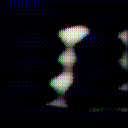

BATCH_SIZE 256
Gen loss: 3.3528645
Disc loss: 0.5896712
Disc accuracy: 0.96484375


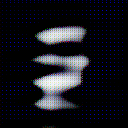

BATCH_SIZE 256
Gen loss: 2.5039108
Disc loss: 0.58072746
Disc accuracy: 0.87890625


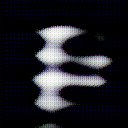

BATCH_SIZE 256
Gen loss: 1.8456459
Disc loss: 0.6180473
Disc accuracy: 0.765625


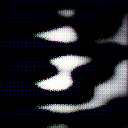

BATCH_SIZE 256
Gen loss: 2.2818573
Disc loss: 0.51453817
Disc accuracy: 0.85546875


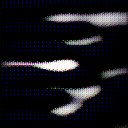

BATCH_SIZE 256
Gen loss: 2.6454349
Disc loss: 0.51828253
Disc accuracy: 0.92578125


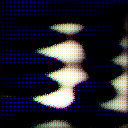

BATCH_SIZE 256
Gen loss: 3.016669
Disc loss: 0.5101637
Disc accuracy: 0.9453125


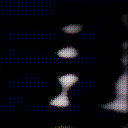

BATCH_SIZE 256
Gen loss: 2.666335
Disc loss: 0.45388073
Disc accuracy: 0.93359375


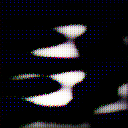

BATCH_SIZE 256
Gen loss: 2.262741
Disc loss: 0.48654145
Disc accuracy: 0.8828125


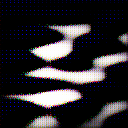

BATCH_SIZE 256
Gen loss: 2.2209783
Disc loss: 0.58104014
Disc accuracy: 0.8203125


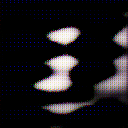

BATCH_SIZE 256
Gen loss: 2.7502155
Disc loss: 0.6069581
Disc accuracy: 0.9140625


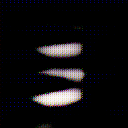

BATCH_SIZE 256
Gen loss: 2.9269166
Disc loss: 0.71831214
Disc accuracy: 0.921875


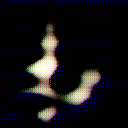

BATCH_SIZE 256
Gen loss: 2.2660425
Disc loss: 0.86302733
Disc accuracy: 0.80078125


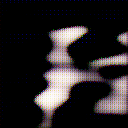

BATCH_SIZE 256
Gen loss: 1.911842
Disc loss: 0.8182157
Disc accuracy: 0.796875


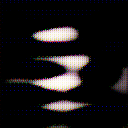

BATCH_SIZE 256
Gen loss: 1.8134245
Disc loss: 0.84777164
Disc accuracy: 0.74609375


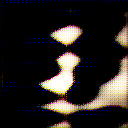

BATCH_SIZE 256
Gen loss: 2.2498324
Disc loss: 1.06332
Disc accuracy: 0.8828125


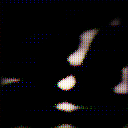

BATCH_SIZE 256
Gen loss: 2.0223625
Disc loss: 1.0813773
Disc accuracy: 0.8125


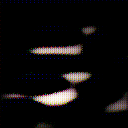

BATCH_SIZE 256
Gen loss: 1.4927361
Disc loss: 1.1510763
Disc accuracy: 0.69921875


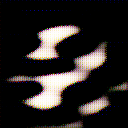

BATCH_SIZE 256
Gen loss: 1.5225648
Disc loss: 1.039824
Disc accuracy: 0.71875


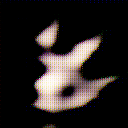

BATCH_SIZE 256
Gen loss: 2.0732214
Disc loss: 1.2226424
Disc accuracy: 0.84375


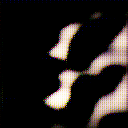

BATCH_SIZE 256
Gen loss: 1.9100902
Disc loss: 1.0574129
Disc accuracy: 0.828125


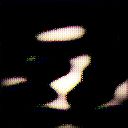

BATCH_SIZE 256
Gen loss: 1.426319
Disc loss: 1.089525
Disc accuracy: 0.60546875


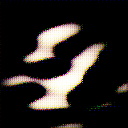

BATCH_SIZE 256
Gen loss: 1.7217094
Disc loss: 1.0164826
Disc accuracy: 0.67578125


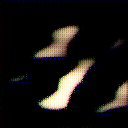

BATCH_SIZE 256
Gen loss: 2.408987
Disc loss: 1.07085
Disc accuracy: 0.80859375


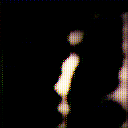

BATCH_SIZE 256
Gen loss: 2.2806654
Disc loss: 0.82943755
Disc accuracy: 0.8359375


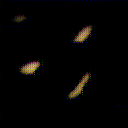

BATCH_SIZE 256
Gen loss: 1.6768464
Disc loss: 0.805721
Disc accuracy: 0.734375


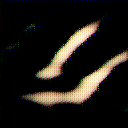

BATCH_SIZE 256
Gen loss: 1.8601431
Disc loss: 0.7611775
Disc accuracy: 0.703125


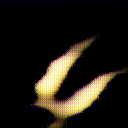

BATCH_SIZE 256
Gen loss: 2.404631
Disc loss: 0.63074684
Disc accuracy: 0.8515625


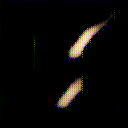

BATCH_SIZE 256
Gen loss: 2.964394
Disc loss: 0.6034795
Disc accuracy: 0.8984375


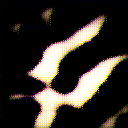

BATCH_SIZE 256
Gen loss: 2.9205346
Disc loss: 0.51606107
Disc accuracy: 0.93359375


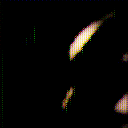

BATCH_SIZE 256
Gen loss: 2.7128875
Disc loss: 0.4644729
Disc accuracy: 0.88671875


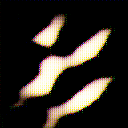

BATCH_SIZE 256
Gen loss: 2.5701923
Disc loss: 0.39048275
Disc accuracy: 0.890625


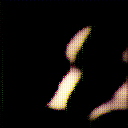

BATCH_SIZE 256
Gen loss: 2.8547592
Disc loss: 0.36066896
Disc accuracy: 0.92578125


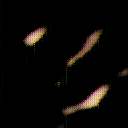

BATCH_SIZE 256
Gen loss: 3.4759784
Disc loss: 0.31237584
Disc accuracy: 0.98046875


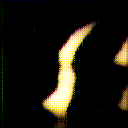

BATCH_SIZE 256
Gen loss: 3.75543
Disc loss: 0.24639899
Disc accuracy: 1.0


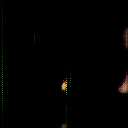

BATCH_SIZE 256
Gen loss: 3.9077444
Disc loss: 0.2745684
Disc accuracy: 0.99609375


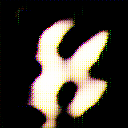

BATCH_SIZE 256
Gen loss: 3.9570284
Disc loss: 0.2037755
Disc accuracy: 1.0


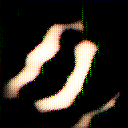

BATCH_SIZE 256
Gen loss: 3.6856546
Disc loss: 0.19323535
Disc accuracy: 0.99609375


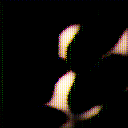

BATCH_SIZE 256
Gen loss: 3.188226
Disc loss: 0.24085298
Disc accuracy: 0.9609375


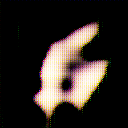

BATCH_SIZE 16
Gen loss: 2.9444551
Disc loss: 0.20561372
Disc accuracy: 0.9375


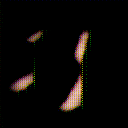


Epoch: 1
BATCH_SIZE 256
Gen loss: 3.7425888
Disc loss: 0.18141338
Disc accuracy: 0.99609375


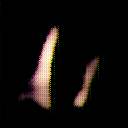

BATCH_SIZE 256
Gen loss: 4.126535
Disc loss: 0.20004085
Disc accuracy: 0.9921875


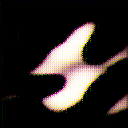

BATCH_SIZE 256
Gen loss: 4.413578
Disc loss: 0.13711695
Disc accuracy: 0.984375


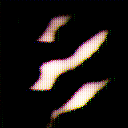

BATCH_SIZE 256
Gen loss: 4.509734
Disc loss: 0.21062294
Disc accuracy: 0.9921875


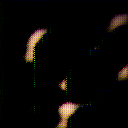

BATCH_SIZE 256
Gen loss: 4.269608
Disc loss: 0.20557868
Disc accuracy: 0.99609375


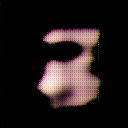

BATCH_SIZE 256
Gen loss: 3.554892
Disc loss: 0.23232843
Disc accuracy: 0.9609375


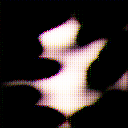

BATCH_SIZE 256
Gen loss: 3.1508431
Disc loss: 0.26733154
Disc accuracy: 0.93359375


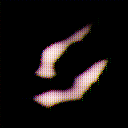

BATCH_SIZE 256
Gen loss: 3.598292
Disc loss: 0.20357421
Disc accuracy: 0.96875


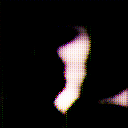

BATCH_SIZE 256
Gen loss: 4.0067515
Disc loss: 0.32909572
Disc accuracy: 0.9765625


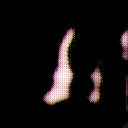

BATCH_SIZE 256
Gen loss: 4.2940006
Disc loss: 0.34525657
Disc accuracy: 0.9765625


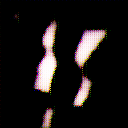

BATCH_SIZE 256
Gen loss: 3.5766375
Disc loss: 0.3142469
Disc accuracy: 0.9609375


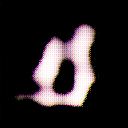

BATCH_SIZE 256
Gen loss: 2.8818197
Disc loss: 0.43039578
Disc accuracy: 0.90234375


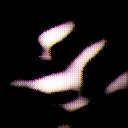

BATCH_SIZE 256
Gen loss: 3.3882413
Disc loss: 0.40233833
Disc accuracy: 0.94921875


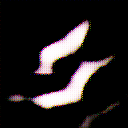

BATCH_SIZE 256
Gen loss: 2.8245554
Disc loss: 0.43029773
Disc accuracy: 0.90625


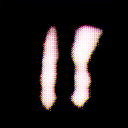

BATCH_SIZE 256
Gen loss: 3.3897939
Disc loss: 0.38410538
Disc accuracy: 0.96484375


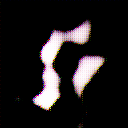

BATCH_SIZE 256
Gen loss: 3.3305867
Disc loss: 0.54871434
Disc accuracy: 0.95703125


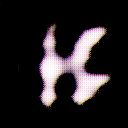

BATCH_SIZE 256
Gen loss: 2.6583145
Disc loss: 0.48065078
Disc accuracy: 0.890625


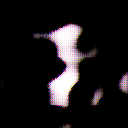

BATCH_SIZE 256
Gen loss: 2.781061
Disc loss: 0.54966295
Disc accuracy: 0.92578125


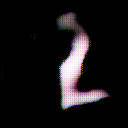

BATCH_SIZE 256
Gen loss: 2.4999003
Disc loss: 0.5886061
Disc accuracy: 0.875


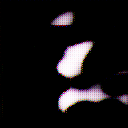

BATCH_SIZE 256
Gen loss: 2.8199158
Disc loss: 0.5871229
Disc accuracy: 0.90625


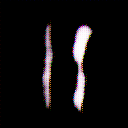

BATCH_SIZE 256
Gen loss: 2.1782956
Disc loss: 0.6451076
Disc accuracy: 0.86328125


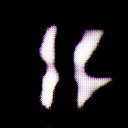

BATCH_SIZE 256
Gen loss: 2.348945
Disc loss: 0.7039026
Disc accuracy: 0.890625


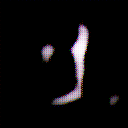

BATCH_SIZE 256
Gen loss: 2.0173187
Disc loss: 0.7029115
Disc accuracy: 0.84765625


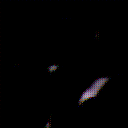

BATCH_SIZE 256
Gen loss: 2.221227
Disc loss: 0.7199167
Disc accuracy: 0.88671875


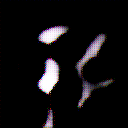

BATCH_SIZE 256
Gen loss: 2.1907158
Disc loss: 0.59541154
Disc accuracy: 0.8984375


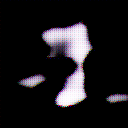

BATCH_SIZE 256
Gen loss: 1.941782
Disc loss: 0.73674333
Disc accuracy: 0.85546875


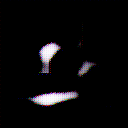

BATCH_SIZE 256
Gen loss: 2.1873004
Disc loss: 0.8069486
Disc accuracy: 0.87109375


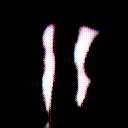

BATCH_SIZE 256
Gen loss: 1.397996
Disc loss: 0.86276233
Disc accuracy: 0.69921875


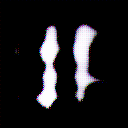

BATCH_SIZE 256
Gen loss: 3.5798764
Disc loss: 1.2394783
Disc accuracy: 1.0


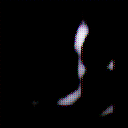

BATCH_SIZE 256
Gen loss: 0.4564955
Disc loss: 1.9123545
Disc accuracy: 0.23828125


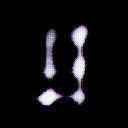

BATCH_SIZE 256
Gen loss: 4.0180016
Disc loss: 1.7479205
Disc accuracy: 1.0


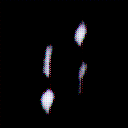

BATCH_SIZE 256
Gen loss: 2.1857967
Disc loss: 1.1577848
Disc accuracy: 0.94140625


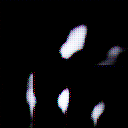

BATCH_SIZE 256
Gen loss: 0.34833303
Disc loss: 1.8108728
Disc accuracy: 0.14453125


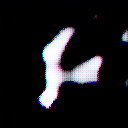

BATCH_SIZE 256
Gen loss: 1.2672932
Disc loss: 0.9328183
Disc accuracy: 0.73046875


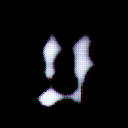

BATCH_SIZE 256
Gen loss: 2.915524
Disc loss: 1.506683
Disc accuracy: 0.9921875


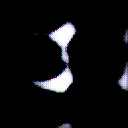

BATCH_SIZE 256
Gen loss: 2.0256898
Disc loss: 1.1251874
Disc accuracy: 0.95703125


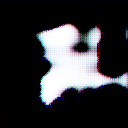

BATCH_SIZE 256
Gen loss: 0.8599321
Disc loss: 1.0235258
Disc accuracy: 0.55078125


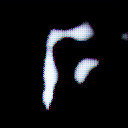

BATCH_SIZE 256
Gen loss: 0.5960776
Disc loss: 1.194507
Disc accuracy: 0.3203125


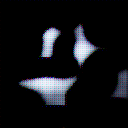

BATCH_SIZE 256
Gen loss: 0.8941533
Disc loss: 0.9440204
Disc accuracy: 0.6171875


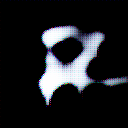

BATCH_SIZE 16
Gen loss: 1.5487261
Disc loss: 1.0403827
Disc accuracy: 1.0


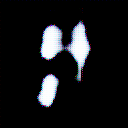


Epoch: 2
BATCH_SIZE 256
Gen loss: 1.7794662
Disc loss: 0.9211651
Disc accuracy: 0.98046875


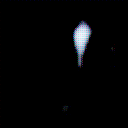

BATCH_SIZE 256
Gen loss: 1.524005
Disc loss: 0.9860826
Disc accuracy: 0.98046875


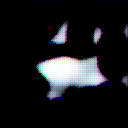

BATCH_SIZE 256
Gen loss: 1.154725
Disc loss: 0.8940004
Disc accuracy: 0.81640625


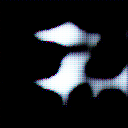

BATCH_SIZE 256
Gen loss: 0.95891696
Disc loss: 0.8911525
Disc accuracy: 0.65234375


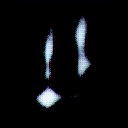

BATCH_SIZE 256
Gen loss: 0.9838133
Disc loss: 0.8657598
Disc accuracy: 0.6875


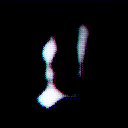

BATCH_SIZE 256
Gen loss: 1.0604784
Disc loss: 0.8536266
Disc accuracy: 0.71484375


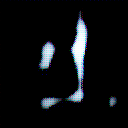

BATCH_SIZE 256
Gen loss: 1.2405179
Disc loss: 0.7361673
Disc accuracy: 0.85546875


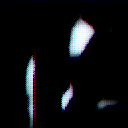

BATCH_SIZE 256
Gen loss: 1.5600464
Disc loss: 0.7386844
Disc accuracy: 0.9609375


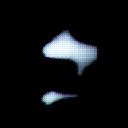

BATCH_SIZE 256
Gen loss: 1.693632
Disc loss: 0.7431898
Disc accuracy: 0.95703125


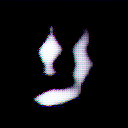

BATCH_SIZE 256
Gen loss: 1.815776
Disc loss: 0.73673177
Disc accuracy: 0.984375


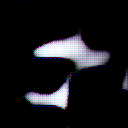

BATCH_SIZE 256
Gen loss: 1.7285893
Disc loss: 0.6440847
Disc accuracy: 0.9609375


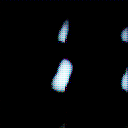

BATCH_SIZE 256
Gen loss: 1.4614178
Disc loss: 0.6613033
Disc accuracy: 0.8984375


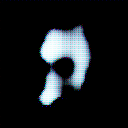

BATCH_SIZE 256
Gen loss: 1.3223431
Disc loss: 0.67381114
Disc accuracy: 0.8828125


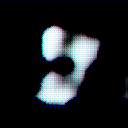

BATCH_SIZE 256
Gen loss: 1.3441559
Disc loss: 0.73369
Disc accuracy: 0.828125


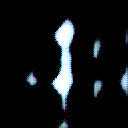

BATCH_SIZE 256
Gen loss: 1.5327295
Disc loss: 0.6450749
Disc accuracy: 0.8828125


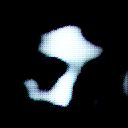

BATCH_SIZE 256
Gen loss: 1.772714
Disc loss: 0.63685966
Disc accuracy: 0.9453125


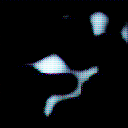

BATCH_SIZE 256
Gen loss: 1.9806328
Disc loss: 0.6132487
Disc accuracy: 0.95703125


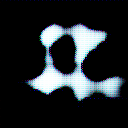

BATCH_SIZE 256
Gen loss: 1.9702306
Disc loss: 0.63160855
Disc accuracy: 0.9453125


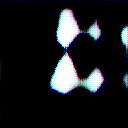

BATCH_SIZE 256
Gen loss: 2.0162277
Disc loss: 0.63329387
Disc accuracy: 0.9140625


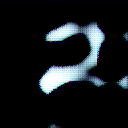

BATCH_SIZE 256
Gen loss: 1.9041104
Disc loss: 0.58071136
Disc accuracy: 0.90234375


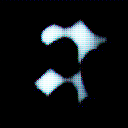

BATCH_SIZE 256
Gen loss: 1.7492101
Disc loss: 0.56733036
Disc accuracy: 0.89453125


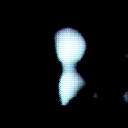

BATCH_SIZE 256
Gen loss: 1.803712
Disc loss: 0.62989354
Disc accuracy: 0.91796875


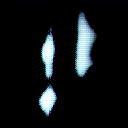

BATCH_SIZE 256
Gen loss: 1.8080964
Disc loss: 0.58660674
Disc accuracy: 0.90234375


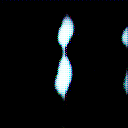

BATCH_SIZE 256
Gen loss: 1.9328253
Disc loss: 0.6306505
Disc accuracy: 0.89453125


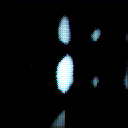

BATCH_SIZE 256
Gen loss: 2.164499
Disc loss: 0.58255637
Disc accuracy: 0.9375


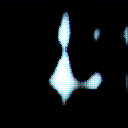

BATCH_SIZE 256
Gen loss: 2.1696382
Disc loss: 0.59319055
Disc accuracy: 0.91015625


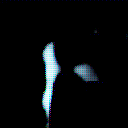

BATCH_SIZE 256
Gen loss: 2.0714867
Disc loss: 0.6491809
Disc accuracy: 0.9296875


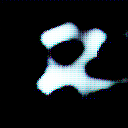

BATCH_SIZE 256
Gen loss: 1.940836
Disc loss: 0.56109554
Disc accuracy: 0.8984375


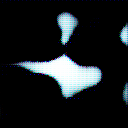

BATCH_SIZE 256
Gen loss: 1.9979761
Disc loss: 0.60236573
Disc accuracy: 0.8984375


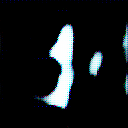

BATCH_SIZE 256
Gen loss: 2.0159094
Disc loss: 0.5530529
Disc accuracy: 0.87890625


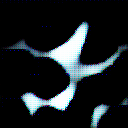

BATCH_SIZE 256
Gen loss: 1.8982706
Disc loss: 0.6938031
Disc accuracy: 0.8671875


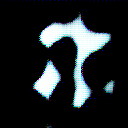

BATCH_SIZE 256
Gen loss: 2.1917856
Disc loss: 0.62220824
Disc accuracy: 0.91796875


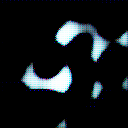

BATCH_SIZE 256
Gen loss: 2.0636911
Disc loss: 0.6119454
Disc accuracy: 0.921875


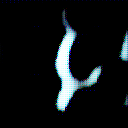

BATCH_SIZE 256
Gen loss: 2.0255868
Disc loss: 0.57788736
Disc accuracy: 0.91796875


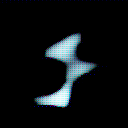

BATCH_SIZE 256
Gen loss: 1.9695652
Disc loss: 0.5053886
Disc accuracy: 0.9140625


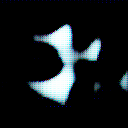

BATCH_SIZE 256
Gen loss: 2.0034342
Disc loss: 0.5977563
Disc accuracy: 0.8984375


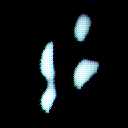

BATCH_SIZE 256
Gen loss: 1.8918912
Disc loss: 0.6395178
Disc accuracy: 0.90625


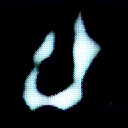

BATCH_SIZE 256
Gen loss: 1.9075739
Disc loss: 0.5756984
Disc accuracy: 0.9140625


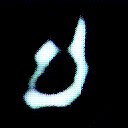

BATCH_SIZE 256
Gen loss: 1.8663738
Disc loss: 0.61962414
Disc accuracy: 0.921875


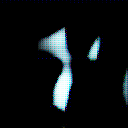

BATCH_SIZE 16
Gen loss: 2.189859
Disc loss: 0.45817927
Disc accuracy: 0.9375


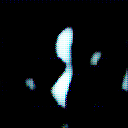


Epoch: 3
BATCH_SIZE 256
Gen loss: 2.0085886
Disc loss: 0.57323635
Disc accuracy: 0.93359375


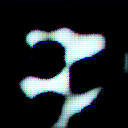

BATCH_SIZE 256
Gen loss: 2.0415401
Disc loss: 0.5331343
Disc accuracy: 0.9453125


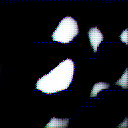

BATCH_SIZE 256
Gen loss: 2.0146515
Disc loss: 0.6242246
Disc accuracy: 0.92578125


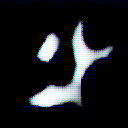

BATCH_SIZE 256
Gen loss: 2.0572321
Disc loss: 0.59290254
Disc accuracy: 0.9375


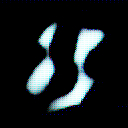

BATCH_SIZE 256
Gen loss: 1.8952081
Disc loss: 0.58610475
Disc accuracy: 0.8984375


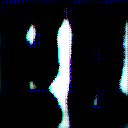

BATCH_SIZE 256
Gen loss: 1.7628694
Disc loss: 0.61712426
Disc accuracy: 0.87109375


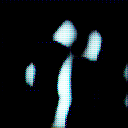

BATCH_SIZE 256
Gen loss: 1.9417871
Disc loss: 0.6168333
Disc accuracy: 0.92578125


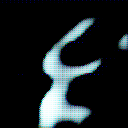

BATCH_SIZE 256
Gen loss: 1.9957643
Disc loss: 0.6698696
Disc accuracy: 0.93359375


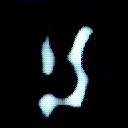

BATCH_SIZE 256
Gen loss: 1.9193529
Disc loss: 0.620687
Disc accuracy: 0.9296875


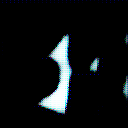

BATCH_SIZE 256
Gen loss: 1.8300803
Disc loss: 0.5972661
Disc accuracy: 0.8984375


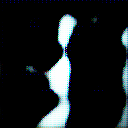

BATCH_SIZE 256
Gen loss: 1.8533977
Disc loss: 0.5547074
Disc accuracy: 0.921875


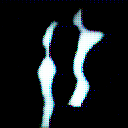

BATCH_SIZE 256
Gen loss: 1.8065732
Disc loss: 0.65159476
Disc accuracy: 0.890625


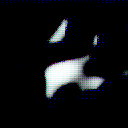

BATCH_SIZE 256
Gen loss: 1.8625363
Disc loss: 0.55006397
Disc accuracy: 0.8984375


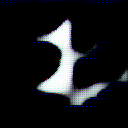

BATCH_SIZE 256
Gen loss: 2.101426
Disc loss: 0.56324553
Disc accuracy: 0.91796875


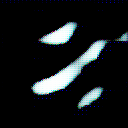

BATCH_SIZE 256
Gen loss: 2.1349778
Disc loss: 0.5203494
Disc accuracy: 0.9765625


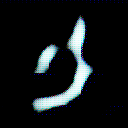

BATCH_SIZE 256
Gen loss: 2.1078596
Disc loss: 0.5124561
Disc accuracy: 0.94140625


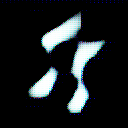

BATCH_SIZE 256
Gen loss: 2.089534
Disc loss: 0.41940022
Disc accuracy: 0.9609375


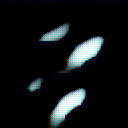

BATCH_SIZE 256
Gen loss: 2.0159743
Disc loss: 0.48688006
Disc accuracy: 0.953125


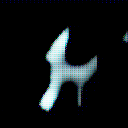

BATCH_SIZE 256
Gen loss: 1.8947027
Disc loss: 0.50348675
Disc accuracy: 0.91796875


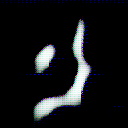

BATCH_SIZE 256
Gen loss: 2.015133
Disc loss: 0.4511729
Disc accuracy: 0.9296875


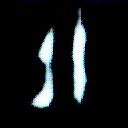

BATCH_SIZE 256
Gen loss: 2.1936991
Disc loss: 0.4204985
Disc accuracy: 0.96484375


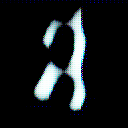

BATCH_SIZE 256
Gen loss: 2.5619035
Disc loss: 0.38711917
Disc accuracy: 0.9765625


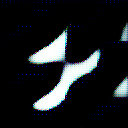

BATCH_SIZE 256
Gen loss: 2.4913392
Disc loss: 0.38402313
Disc accuracy: 0.9765625


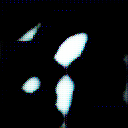

BATCH_SIZE 256
Gen loss: 2.3635535
Disc loss: 0.38317168
Disc accuracy: 0.97265625


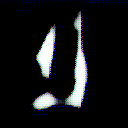

BATCH_SIZE 256
Gen loss: 2.3401203
Disc loss: 0.3930049
Disc accuracy: 0.95703125


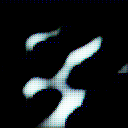

BATCH_SIZE 256
Gen loss: 2.3481994
Disc loss: 0.37773505
Disc accuracy: 0.9609375


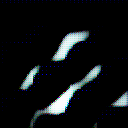

BATCH_SIZE 256
Gen loss: 2.390233
Disc loss: 0.34677157
Disc accuracy: 0.94921875


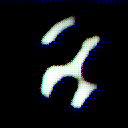

BATCH_SIZE 256
Gen loss: 2.5930324
Disc loss: 0.31777936
Disc accuracy: 0.96875


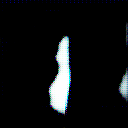

BATCH_SIZE 256
Gen loss: 2.744022
Disc loss: 0.33105606
Disc accuracy: 0.96484375


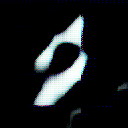

BATCH_SIZE 256
Gen loss: 2.825289
Disc loss: 0.3310613
Disc accuracy: 0.97265625


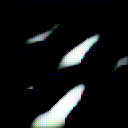

BATCH_SIZE 256
Gen loss: 2.8902133
Disc loss: 0.3495679
Disc accuracy: 0.98046875


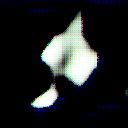

BATCH_SIZE 256
Gen loss: 2.6748898
Disc loss: 0.325692
Disc accuracy: 0.9609375


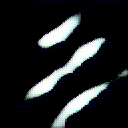

BATCH_SIZE 256
Gen loss: 2.5190465
Disc loss: 0.3233832
Disc accuracy: 0.94921875


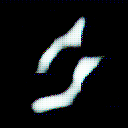

BATCH_SIZE 256
Gen loss: 2.5412965
Disc loss: 0.34362987
Disc accuracy: 0.9296875


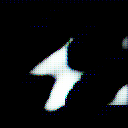

BATCH_SIZE 256
Gen loss: 2.981333
Disc loss: 0.29071978
Disc accuracy: 0.9765625


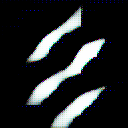

BATCH_SIZE 256
Gen loss: 3.2823555
Disc loss: 0.33731726
Disc accuracy: 0.98828125


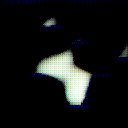

BATCH_SIZE 256
Gen loss: 3.1414778
Disc loss: 0.30142877
Disc accuracy: 0.984375


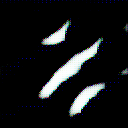

BATCH_SIZE 256
Gen loss: 2.8369703
Disc loss: 0.23918423
Disc accuracy: 0.921875


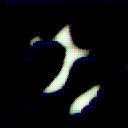

BATCH_SIZE 256
Gen loss: 2.756754
Disc loss: 0.3134161
Disc accuracy: 0.9140625


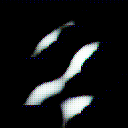

BATCH_SIZE 16
Gen loss: 3.650759
Disc loss: 0.14007945
Disc accuracy: 1.0


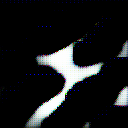


Epoch: 4
BATCH_SIZE 256
Gen loss: 3.3789744
Disc loss: 0.35295668
Disc accuracy: 0.95703125


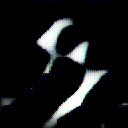

BATCH_SIZE 256
Gen loss: 3.088375
Disc loss: 0.4281389
Disc accuracy: 0.8984375


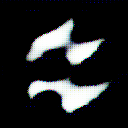

BATCH_SIZE 256
Gen loss: 3.243601
Disc loss: 0.35163987
Disc accuracy: 0.94140625


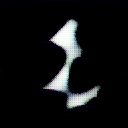

BATCH_SIZE 256
Gen loss: 3.2737415
Disc loss: 0.4941228
Disc accuracy: 0.9140625


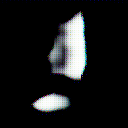

BATCH_SIZE 256
Gen loss: 3.0039527
Disc loss: 0.49475402
Disc accuracy: 0.87890625


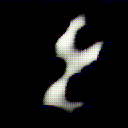

BATCH_SIZE 256
Gen loss: 3.0599465
Disc loss: 0.34432337
Disc accuracy: 0.94140625


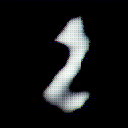

BATCH_SIZE 256
Gen loss: 2.757389
Disc loss: 0.41181397
Disc accuracy: 0.8984375


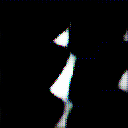

BATCH_SIZE 256
Gen loss: 3.403552
Disc loss: 0.45692217
Disc accuracy: 0.9296875


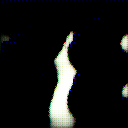

BATCH_SIZE 256
Gen loss: 3.4709895
Disc loss: 0.5001023
Disc accuracy: 0.953125


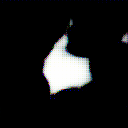

BATCH_SIZE 256
Gen loss: 2.7377937
Disc loss: 0.43403065
Disc accuracy: 0.87890625


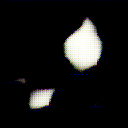

BATCH_SIZE 256
Gen loss: 2.5128927
Disc loss: 0.520347
Disc accuracy: 0.87890625


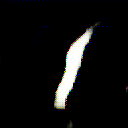

BATCH_SIZE 256
Gen loss: 3.2134447
Disc loss: 0.5145339
Disc accuracy: 0.94140625


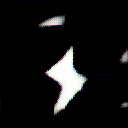

BATCH_SIZE 256
Gen loss: 2.9327826
Disc loss: 0.5453807
Disc accuracy: 0.9375


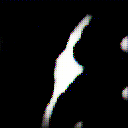

BATCH_SIZE 256
Gen loss: 1.9379038
Disc loss: 0.6128614
Disc accuracy: 0.7890625


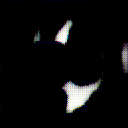

BATCH_SIZE 256
Gen loss: 3.257233
Disc loss: 0.48622614
Disc accuracy: 0.96484375


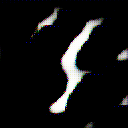

BATCH_SIZE 256
Gen loss: 3.2898233
Disc loss: 0.5804772
Disc accuracy: 0.9609375


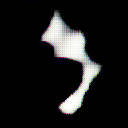

BATCH_SIZE 256
Gen loss: 2.3570497
Disc loss: 0.5118818
Disc accuracy: 0.8828125


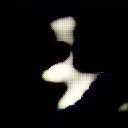

BATCH_SIZE 256
Gen loss: 2.2854104
Disc loss: 0.5350552
Disc accuracy: 0.8515625


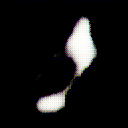

BATCH_SIZE 256
Gen loss: 3.0375376
Disc loss: 0.5577882
Disc accuracy: 0.9375


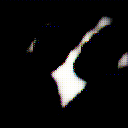

BATCH_SIZE 256
Gen loss: 3.1995358
Disc loss: 0.64953434
Disc accuracy: 0.94140625


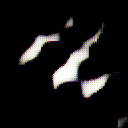

BATCH_SIZE 256
Gen loss: 1.9053478
Disc loss: 0.6893308
Disc accuracy: 0.74609375


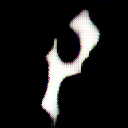

BATCH_SIZE 256
Gen loss: 2.8031304
Disc loss: 0.5351814
Disc accuracy: 0.92578125


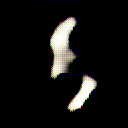

BATCH_SIZE 256
Gen loss: 3.1995742
Disc loss: 0.6021994
Disc accuracy: 0.96875


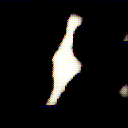

BATCH_SIZE 256
Gen loss: 2.1602526
Disc loss: 0.6579752
Disc accuracy: 0.8671875


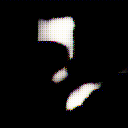

BATCH_SIZE 256
Gen loss: 2.1379173
Disc loss: 0.7323923
Disc accuracy: 0.8828125


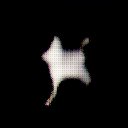

BATCH_SIZE 256
Gen loss: 2.6433277
Disc loss: 0.76323366
Disc accuracy: 0.8984375


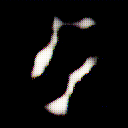

BATCH_SIZE 256
Gen loss: 2.5331464
Disc loss: 0.6388963
Disc accuracy: 0.89453125


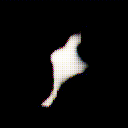

BATCH_SIZE 256
Gen loss: 2.0763261
Disc loss: 0.8447039
Disc accuracy: 0.7734375


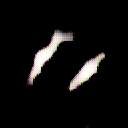

BATCH_SIZE 256
Gen loss: 2.7101774
Disc loss: 0.89307404
Disc accuracy: 0.90234375


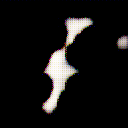

BATCH_SIZE 256
Gen loss: 2.0696883
Disc loss: 0.7871832
Disc accuracy: 0.8359375


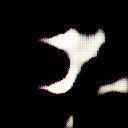

BATCH_SIZE 256
Gen loss: 1.9449112
Disc loss: 0.89907044
Disc accuracy: 0.8125


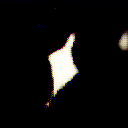

BATCH_SIZE 256
Gen loss: 2.74406
Disc loss: 0.85685515
Disc accuracy: 0.8984375


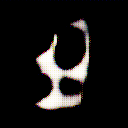

BATCH_SIZE 256
Gen loss: 2.11643
Disc loss: 0.8593023
Disc accuracy: 0.84765625


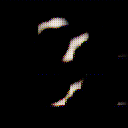

BATCH_SIZE 256
Gen loss: 1.4630731
Disc loss: 1.0214894
Disc accuracy: 0.6796875


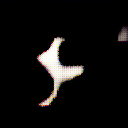

BATCH_SIZE 256
Gen loss: 2.5175908
Disc loss: 0.9625092
Disc accuracy: 0.90234375


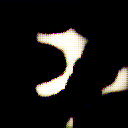

BATCH_SIZE 256
Gen loss: 2.1395879
Disc loss: 0.7936182
Disc accuracy: 0.8828125


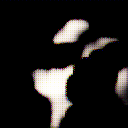

BATCH_SIZE 256
Gen loss: 1.4311322
Disc loss: 0.85715234
Disc accuracy: 0.7421875


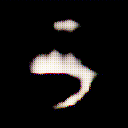

BATCH_SIZE 256
Gen loss: 2.0597026
Disc loss: 0.7250953
Disc accuracy: 0.8828125


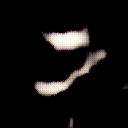

BATCH_SIZE 256
Gen loss: 2.3179424
Disc loss: 0.8144177
Disc accuracy: 0.94140625


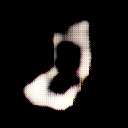

BATCH_SIZE 16
Gen loss: 1.4385002
Disc loss: 0.77947086
Disc accuracy: 0.6875


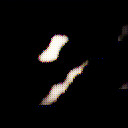


Epoch: 5
BATCH_SIZE 256
Gen loss: 2.8215384
Disc loss: 0.86222255
Disc accuracy: 0.95703125


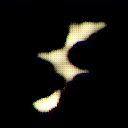

BATCH_SIZE 256
Gen loss: 2.1659343
Disc loss: 0.62360847
Disc accuracy: 0.890625


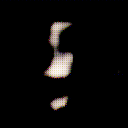

BATCH_SIZE 256
Gen loss: 1.7361687
Disc loss: 0.7244387
Disc accuracy: 0.77734375


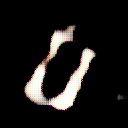

BATCH_SIZE 256
Gen loss: 1.8179533
Disc loss: 0.6947946
Disc accuracy: 0.80078125


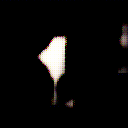

BATCH_SIZE 256
Gen loss: 2.2684128
Disc loss: 0.6506309
Disc accuracy: 0.91015625


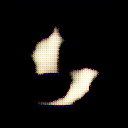

BATCH_SIZE 256
Gen loss: 2.5484252
Disc loss: 0.6707435
Disc accuracy: 0.9609375


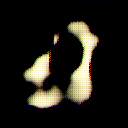

BATCH_SIZE 256
Gen loss: 2.2480137
Disc loss: 0.5875214
Disc accuracy: 0.9375


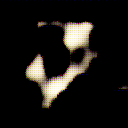

BATCH_SIZE 256
Gen loss: 1.6422673
Disc loss: 0.643213
Disc accuracy: 0.8203125


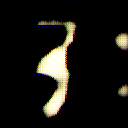

BATCH_SIZE 256
Gen loss: 1.6935081
Disc loss: 0.6488402
Disc accuracy: 0.76953125


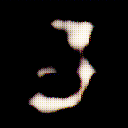

BATCH_SIZE 256
Gen loss: 1.9919137
Disc loss: 0.5595337
Disc accuracy: 0.91796875


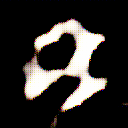

BATCH_SIZE 256
Gen loss: 2.3871017
Disc loss: 0.61868846
Disc accuracy: 0.9296875


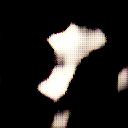

BATCH_SIZE 256
Gen loss: 2.3611226
Disc loss: 0.63170373
Disc accuracy: 0.9296875


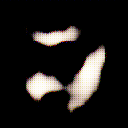

BATCH_SIZE 256
Gen loss: 2.2233148
Disc loss: 0.54915357
Disc accuracy: 0.91015625


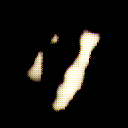

BATCH_SIZE 256
Gen loss: 1.9061346
Disc loss: 0.60270816
Disc accuracy: 0.81640625


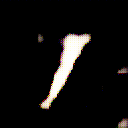

BATCH_SIZE 256
Gen loss: 1.996604
Disc loss: 0.63268083
Disc accuracy: 0.83984375


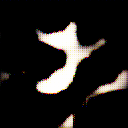

BATCH_SIZE 256
Gen loss: 2.2047215
Disc loss: 0.67374605
Disc accuracy: 0.8203125


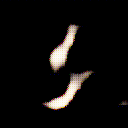

BATCH_SIZE 256
Gen loss: 2.316874
Disc loss: 0.74011075
Disc accuracy: 0.9140625


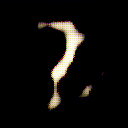

BATCH_SIZE 256
Gen loss: 2.3568025
Disc loss: 0.75730765
Disc accuracy: 0.87890625


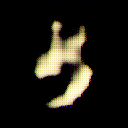

BATCH_SIZE 256
Gen loss: 2.0504866
Disc loss: 0.71269596
Disc accuracy: 0.80078125


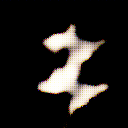

BATCH_SIZE 256
Gen loss: 1.9583323
Disc loss: 0.7885132
Disc accuracy: 0.828125


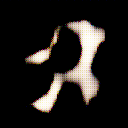

BATCH_SIZE 256
Gen loss: 2.301682
Disc loss: 0.7890752
Disc accuracy: 0.859375


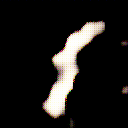

BATCH_SIZE 256
Gen loss: 2.1303103
Disc loss: 0.8091936
Disc accuracy: 0.84765625


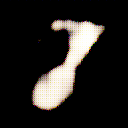

BATCH_SIZE 256
Gen loss: 2.467227
Disc loss: 0.6446717
Disc accuracy: 0.9140625


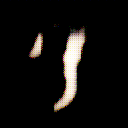

BATCH_SIZE 256
Gen loss: 2.1822479
Disc loss: 0.71264386
Disc accuracy: 0.87890625


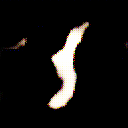

BATCH_SIZE 256
Gen loss: 2.136621
Disc loss: 0.7516282
Disc accuracy: 0.84765625


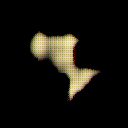

BATCH_SIZE 256
Gen loss: 2.018502
Disc loss: 0.8066832
Disc accuracy: 0.875


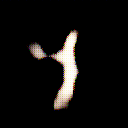

BATCH_SIZE 256
Gen loss: 2.0596178
Disc loss: 0.7373859
Disc accuracy: 0.86328125


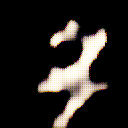

BATCH_SIZE 256
Gen loss: 2.2428977
Disc loss: 0.646253
Disc accuracy: 0.890625


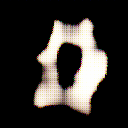

BATCH_SIZE 256
Gen loss: 2.4797847
Disc loss: 0.54319686
Disc accuracy: 0.92578125


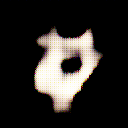

BATCH_SIZE 256
Gen loss: 2.5646877
Disc loss: 0.5580551
Disc accuracy: 0.9453125


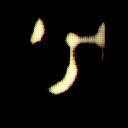

BATCH_SIZE 256
Gen loss: 2.4511378
Disc loss: 0.6445854
Disc accuracy: 0.8984375


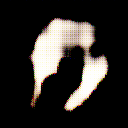

BATCH_SIZE 256
Gen loss: 2.5575836
Disc loss: 0.48417145
Disc accuracy: 0.94140625


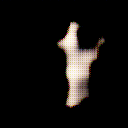

BATCH_SIZE 256
Gen loss: 2.3315873
Disc loss: 0.51145256
Disc accuracy: 0.90234375


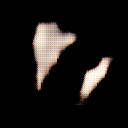

BATCH_SIZE 256
Gen loss: 2.5099769
Disc loss: 0.49942058
Disc accuracy: 0.91015625


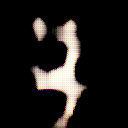

BATCH_SIZE 256
Gen loss: 3.0325568
Disc loss: 0.44703484
Disc accuracy: 0.9453125


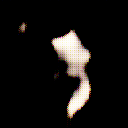

BATCH_SIZE 256
Gen loss: 3.1077194
Disc loss: 0.32897592
Disc accuracy: 0.96484375


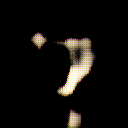

BATCH_SIZE 256
Gen loss: 2.975779
Disc loss: 0.33789408
Disc accuracy: 0.95703125


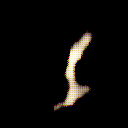

BATCH_SIZE 256
Gen loss: 2.9631407
Disc loss: 0.30264103
Disc accuracy: 0.9375


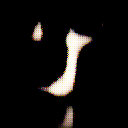

BATCH_SIZE 256
Gen loss: 3.0187113
Disc loss: 0.38529092
Disc accuracy: 0.91796875


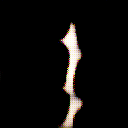

BATCH_SIZE 16
Gen loss: 2.8800576
Disc loss: 0.3652279
Disc accuracy: 0.875


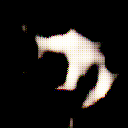


Epoch: 6
BATCH_SIZE 256
Gen loss: 4.361578
Disc loss: 0.42429227
Disc accuracy: 0.9765625


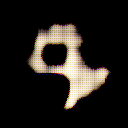

BATCH_SIZE 256
Gen loss: 3.837811
Disc loss: 0.36381888
Disc accuracy: 0.9765625


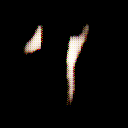

BATCH_SIZE 256
Gen loss: 3.1021314
Disc loss: 0.2925498
Disc accuracy: 0.93359375


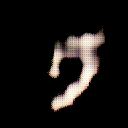

BATCH_SIZE 256
Gen loss: 2.8737495
Disc loss: 0.37088478
Disc accuracy: 0.87890625


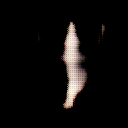

BATCH_SIZE 256
Gen loss: 3.1303902
Disc loss: 0.30169517
Disc accuracy: 0.9296875


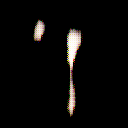

BATCH_SIZE 256
Gen loss: 3.9803317
Disc loss: 0.36669543
Disc accuracy: 0.9609375


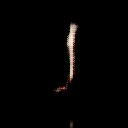

BATCH_SIZE 256
Gen loss: 3.8455825
Disc loss: 0.5199002
Disc accuracy: 0.9375


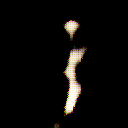

BATCH_SIZE 256
Gen loss: 3.4212835
Disc loss: 0.31206468
Disc accuracy: 0.9296875


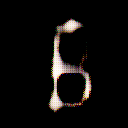

BATCH_SIZE 256
Gen loss: 3.118164
Disc loss: 0.5000459
Disc accuracy: 0.90234375


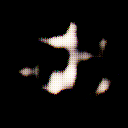

BATCH_SIZE 256
Gen loss: 3.041033
Disc loss: 0.45957017
Disc accuracy: 0.91796875


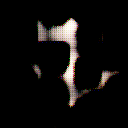

BATCH_SIZE 256
Gen loss: 2.6706507
Disc loss: 0.5214956
Disc accuracy: 0.87890625


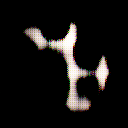

BATCH_SIZE 256
Gen loss: 3.1741514
Disc loss: 0.61166143
Disc accuracy: 0.875


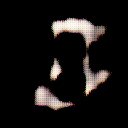

BATCH_SIZE 256
Gen loss: 3.4610715
Disc loss: 0.6023189
Disc accuracy: 0.91796875


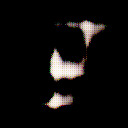

BATCH_SIZE 256
Gen loss: 3.559032
Disc loss: 0.7012359
Disc accuracy: 0.90234375


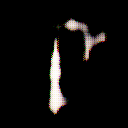

BATCH_SIZE 256
Gen loss: 2.4734287
Disc loss: 0.63227487
Disc accuracy: 0.83203125


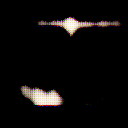

BATCH_SIZE 256
Gen loss: 2.2519584
Disc loss: 0.6933661
Disc accuracy: 0.81640625


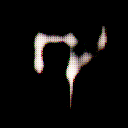

BATCH_SIZE 256
Gen loss: 3.2799306
Disc loss: 0.59227747
Disc accuracy: 0.93359375


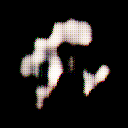

BATCH_SIZE 256
Gen loss: 3.2986226
Disc loss: 0.50401986
Disc accuracy: 0.92578125


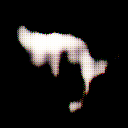

BATCH_SIZE 256
Gen loss: 2.7568038
Disc loss: 0.537203
Disc accuracy: 0.90234375


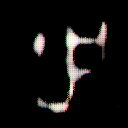

BATCH_SIZE 256
Gen loss: 2.3461962
Disc loss: 0.58215594
Disc accuracy: 0.828125


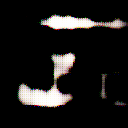

BATCH_SIZE 256
Gen loss: 2.7835174
Disc loss: 0.43809682
Disc accuracy: 0.91796875


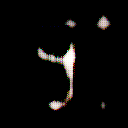

BATCH_SIZE 256
Gen loss: 3.1222727
Disc loss: 0.42670244
Disc accuracy: 0.94140625


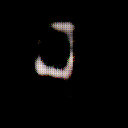

BATCH_SIZE 256
Gen loss: 3.5699294
Disc loss: 0.35697052
Disc accuracy: 0.95703125


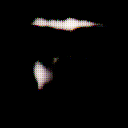

BATCH_SIZE 256
Gen loss: 3.4038897
Disc loss: 0.40776592
Disc accuracy: 0.94140625


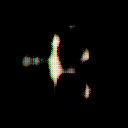

BATCH_SIZE 256
Gen loss: 3.0314262
Disc loss: 0.37235957
Disc accuracy: 0.9296875


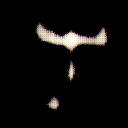

BATCH_SIZE 256
Gen loss: 2.5517755
Disc loss: 0.35806865
Disc accuracy: 0.8984375


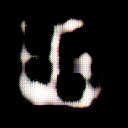

BATCH_SIZE 256
Gen loss: 3.3858974
Disc loss: 0.2447918
Disc accuracy: 0.9609375


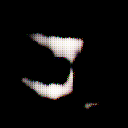

BATCH_SIZE 256
Gen loss: 3.8745632
Disc loss: 0.30608833
Disc accuracy: 0.98046875


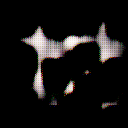

BATCH_SIZE 256
Gen loss: 4.093093
Disc loss: 0.28920358
Disc accuracy: 0.98828125


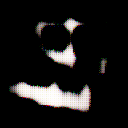

BATCH_SIZE 256
Gen loss: 3.8970718
Disc loss: 0.2840584
Disc accuracy: 0.98046875


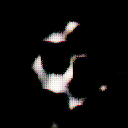

BATCH_SIZE 256
Gen loss: 2.8143644
Disc loss: 0.3841108
Disc accuracy: 0.88671875


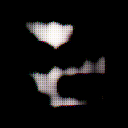

BATCH_SIZE 256
Gen loss: 3.2546263
Disc loss: 0.32450768
Disc accuracy: 0.921875


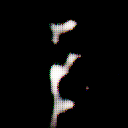

BATCH_SIZE 256
Gen loss: 4.1716604
Disc loss: 0.42949003
Disc accuracy: 0.9765625


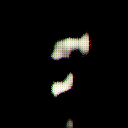

BATCH_SIZE 256
Gen loss: 3.4776456
Disc loss: 0.42870367
Disc accuracy: 0.94140625


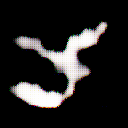

BATCH_SIZE 256
Gen loss: 3.2708921
Disc loss: 0.43727627
Disc accuracy: 0.9140625


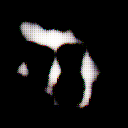

BATCH_SIZE 256
Gen loss: 2.7986958
Disc loss: 0.36259183
Disc accuracy: 0.90625


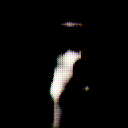

BATCH_SIZE 256
Gen loss: 2.8780506
Disc loss: 0.5220953
Disc accuracy: 0.8984375


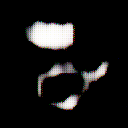

BATCH_SIZE 256
Gen loss: 3.9046297
Disc loss: 0.6316048
Disc accuracy: 0.9609375


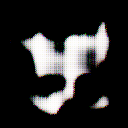

BATCH_SIZE 256
Gen loss: 2.707488
Disc loss: 0.58535707
Disc accuracy: 0.859375


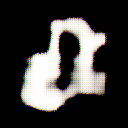

BATCH_SIZE 16
Gen loss: 3.1813495
Disc loss: 0.9804983
Disc accuracy: 0.9375


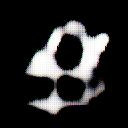


Epoch: 7
BATCH_SIZE 256
Gen loss: 1.551058
Disc loss: 0.9896738
Disc accuracy: 0.59765625


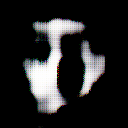

BATCH_SIZE 256
Gen loss: 3.726166
Disc loss: 0.70168203
Disc accuracy: 0.96875


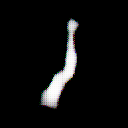

BATCH_SIZE 256
Gen loss: 4.082242
Disc loss: 0.90029013
Disc accuracy: 0.98828125


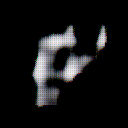

BATCH_SIZE 256
Gen loss: 1.7749405
Disc loss: 0.6836926
Disc accuracy: 0.7734375


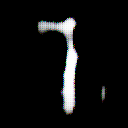

BATCH_SIZE 256
Gen loss: 1.5744152
Disc loss: 0.7123792
Disc accuracy: 0.71875


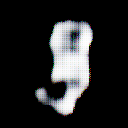

BATCH_SIZE 256
Gen loss: 2.9972687
Disc loss: 0.6176951
Disc accuracy: 0.9609375


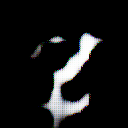

BATCH_SIZE 256
Gen loss: 3.3622746
Disc loss: 0.74558467
Disc accuracy: 0.98046875


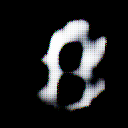

BATCH_SIZE 256
Gen loss: 2.5232654
Disc loss: 0.46854344
Disc accuracy: 0.953125


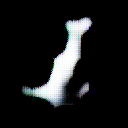

BATCH_SIZE 256
Gen loss: 1.8141464
Disc loss: 0.583097
Disc accuracy: 0.84765625


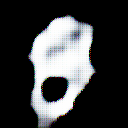

BATCH_SIZE 256
Gen loss: 1.8031662
Disc loss: 0.69995457
Disc accuracy: 0.82421875


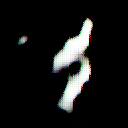

BATCH_SIZE 256
Gen loss: 2.183143
Disc loss: 0.47054797
Disc accuracy: 0.9140625


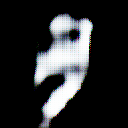

BATCH_SIZE 256
Gen loss: 2.8783386
Disc loss: 0.4167715
Disc accuracy: 0.9765625


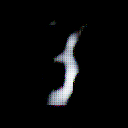

BATCH_SIZE 256
Gen loss: 3.289872
Disc loss: 0.5293471
Disc accuracy: 0.97265625


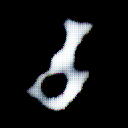

BATCH_SIZE 256
Gen loss: 2.7308016
Disc loss: 0.4946118
Disc accuracy: 0.94140625


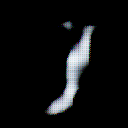

BATCH_SIZE 256
Gen loss: 2.3030694
Disc loss: 0.41862255
Disc accuracy: 0.91015625


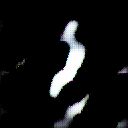

BATCH_SIZE 256
Gen loss: 2.0061226
Disc loss: 0.4215826
Disc accuracy: 0.89453125


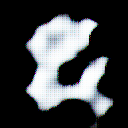

BATCH_SIZE 256
Gen loss: 2.3698878
Disc loss: 0.4111904
Disc accuracy: 0.90625


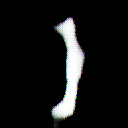

BATCH_SIZE 256
Gen loss: 2.8527565
Disc loss: 0.36446202
Disc accuracy: 0.95703125


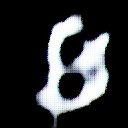

BATCH_SIZE 256
Gen loss: 3.5364542
Disc loss: 0.34507835
Disc accuracy: 0.984375


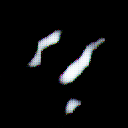

BATCH_SIZE 256
Gen loss: 3.4045672
Disc loss: 0.35824102
Disc accuracy: 0.9765625


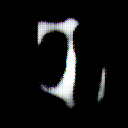

BATCH_SIZE 256
Gen loss: 3.2523284
Disc loss: 0.28450328
Disc accuracy: 0.97265625


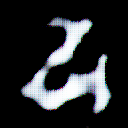

BATCH_SIZE 256
Gen loss: 2.6875694
Disc loss: 0.28827006
Disc accuracy: 0.94921875


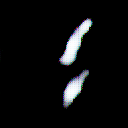

BATCH_SIZE 256
Gen loss: 2.3863268
Disc loss: 0.3894939
Disc accuracy: 0.90234375


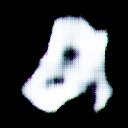

BATCH_SIZE 256
Gen loss: 2.7930443
Disc loss: 0.32011175
Disc accuracy: 0.9609375


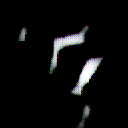

BATCH_SIZE 256
Gen loss: 3.5060356
Disc loss: 0.30014747
Disc accuracy: 0.97265625


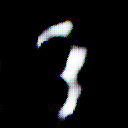

BATCH_SIZE 256
Gen loss: 3.8227115
Disc loss: 0.31202355
Disc accuracy: 0.984375


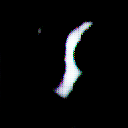

BATCH_SIZE 256
Gen loss: 3.4028537
Disc loss: 0.3892439
Disc accuracy: 0.96875


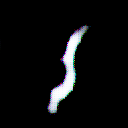

BATCH_SIZE 256
Gen loss: 2.9665205
Disc loss: 0.4038533
Disc accuracy: 0.93359375


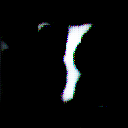

BATCH_SIZE 256
Gen loss: 2.5684764
Disc loss: 0.35890514
Disc accuracy: 0.89453125


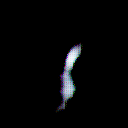

BATCH_SIZE 256
Gen loss: 2.6122422
Disc loss: 0.45445403
Disc accuracy: 0.875


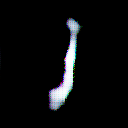

BATCH_SIZE 256
Gen loss: 3.063821
Disc loss: 0.41739088
Disc accuracy: 0.92578125


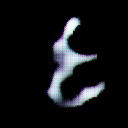

BATCH_SIZE 256
Gen loss: 3.3854778
Disc loss: 0.3739695
Disc accuracy: 0.95703125


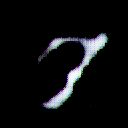

BATCH_SIZE 256
Gen loss: 3.5499423
Disc loss: 0.47208273
Disc accuracy: 0.953125


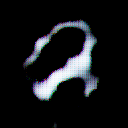

BATCH_SIZE 256
Gen loss: 2.9468338
Disc loss: 0.56247455
Disc accuracy: 0.8984375


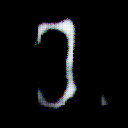

BATCH_SIZE 256
Gen loss: 2.8539283
Disc loss: 0.49100652
Disc accuracy: 0.8828125


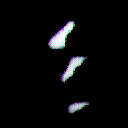

BATCH_SIZE 256
Gen loss: 2.4517093
Disc loss: 0.63631666
Disc accuracy: 0.86328125


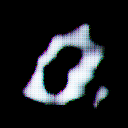

BATCH_SIZE 256
Gen loss: 2.9306285
Disc loss: 0.6149746
Disc accuracy: 0.90234375


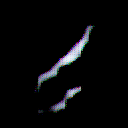

BATCH_SIZE 256
Gen loss: 2.7101057
Disc loss: 0.69442904
Disc accuracy: 0.8359375


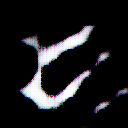

BATCH_SIZE 256
Gen loss: 2.7062187
Disc loss: 0.6631025
Disc accuracy: 0.88671875


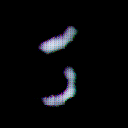

BATCH_SIZE 16
Gen loss: 2.9639606
Disc loss: 0.84245116
Disc accuracy: 0.875


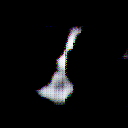


Epoch: 8
BATCH_SIZE 256
Gen loss: 2.4689288
Disc loss: 0.7338767
Disc accuracy: 0.84765625


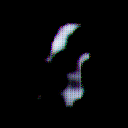

BATCH_SIZE 256
Gen loss: 2.2764306
Disc loss: 0.8219366
Disc accuracy: 0.78515625


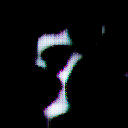

BATCH_SIZE 256
Gen loss: 2.463587
Disc loss: 0.8585865
Disc accuracy: 0.859375


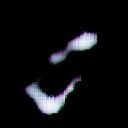

BATCH_SIZE 256
Gen loss: 3.038948
Disc loss: 0.9555614
Disc accuracy: 0.9296875


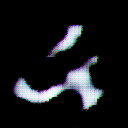

BATCH_SIZE 256
Gen loss: 2.4629703
Disc loss: 0.9448774
Disc accuracy: 0.84375


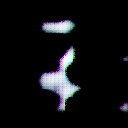

BATCH_SIZE 256
Gen loss: 1.8755367
Disc loss: 0.81076837
Disc accuracy: 0.7890625


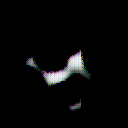

BATCH_SIZE 256
Gen loss: 2.0079184
Disc loss: 0.54956216
Disc accuracy: 0.8828125


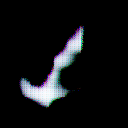

BATCH_SIZE 256
Gen loss: 2.071168
Disc loss: 0.5778903
Disc accuracy: 0.890625


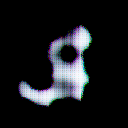

BATCH_SIZE 256
Gen loss: 2.440271
Disc loss: 0.6256182
Disc accuracy: 0.8828125


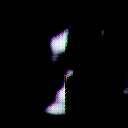

BATCH_SIZE 256
Gen loss: 2.570155
Disc loss: 0.6498263
Disc accuracy: 0.9140625


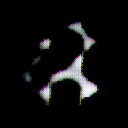

BATCH_SIZE 256
Gen loss: 2.1676464
Disc loss: 0.60458493
Disc accuracy: 0.86328125


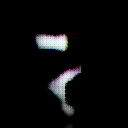

BATCH_SIZE 256
Gen loss: 1.8732246
Disc loss: 0.6314211
Disc accuracy: 0.80859375


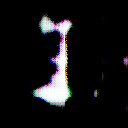

BATCH_SIZE 256
Gen loss: 2.032258
Disc loss: 0.50445473
Disc accuracy: 0.8671875


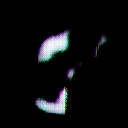

BATCH_SIZE 256
Gen loss: 2.1898594
Disc loss: 0.53846025
Disc accuracy: 0.890625


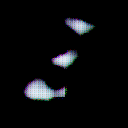

BATCH_SIZE 256
Gen loss: 2.7392154
Disc loss: 0.490288
Disc accuracy: 0.96875


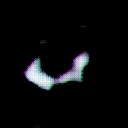

BATCH_SIZE 256
Gen loss: 2.6752758
Disc loss: 0.44430643
Disc accuracy: 0.9375


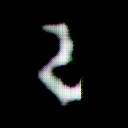

BATCH_SIZE 256
Gen loss: 2.481204
Disc loss: 0.4519859
Disc accuracy: 0.95703125


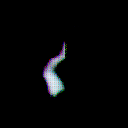

BATCH_SIZE 256
Gen loss: 2.245116
Disc loss: 0.47076127
Disc accuracy: 0.90234375


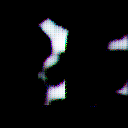

BATCH_SIZE 256
Gen loss: 2.1726308
Disc loss: 0.42197227
Disc accuracy: 0.91015625


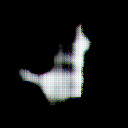

BATCH_SIZE 256
Gen loss: 2.3536615
Disc loss: 0.38780564
Disc accuracy: 0.9140625


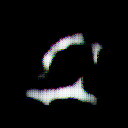

BATCH_SIZE 256
Gen loss: 3.0026069
Disc loss: 0.403084
Disc accuracy: 0.94140625


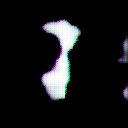

BATCH_SIZE 256
Gen loss: 2.9375155
Disc loss: 0.34682238
Disc accuracy: 0.9453125


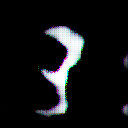

BATCH_SIZE 256
Gen loss: 3.2063293
Disc loss: 0.34415102
Disc accuracy: 0.98046875


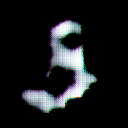

BATCH_SIZE 256
Gen loss: 2.937982
Disc loss: 0.39169252
Disc accuracy: 0.93359375


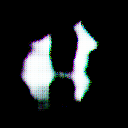

BATCH_SIZE 256
Gen loss: 2.7175016
Disc loss: 0.35135296
Disc accuracy: 0.93359375


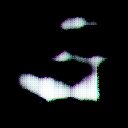

BATCH_SIZE 256
Gen loss: 2.2884655
Disc loss: 0.49347803
Disc accuracy: 0.8515625


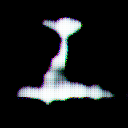

BATCH_SIZE 256
Gen loss: 3.0602906
Disc loss: 0.36699796
Disc accuracy: 0.95703125


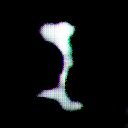

BATCH_SIZE 256
Gen loss: 3.359566
Disc loss: 0.4023912
Disc accuracy: 0.953125


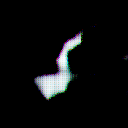

BATCH_SIZE 256
Gen loss: 3.5477357
Disc loss: 0.42734936
Disc accuracy: 0.97265625


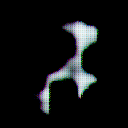

BATCH_SIZE 256
Gen loss: 2.7892125
Disc loss: 0.4946153
Disc accuracy: 0.9140625


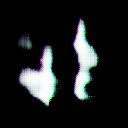

BATCH_SIZE 256
Gen loss: 2.582995
Disc loss: 0.54360795
Disc accuracy: 0.875


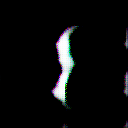

BATCH_SIZE 256
Gen loss: 2.4500268
Disc loss: 0.5264708
Disc accuracy: 0.85546875


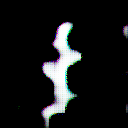

BATCH_SIZE 256
Gen loss: 3.2375832
Disc loss: 0.68835807
Disc accuracy: 0.953125


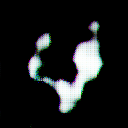

BATCH_SIZE 256
Gen loss: 2.353793
Disc loss: 0.58838415
Disc accuracy: 0.8671875


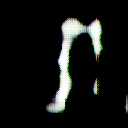

BATCH_SIZE 256
Gen loss: 2.4430094
Disc loss: 0.60110855
Disc accuracy: 0.85546875


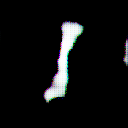

BATCH_SIZE 256
Gen loss: 2.5506272
Disc loss: 0.6079872
Disc accuracy: 0.90625


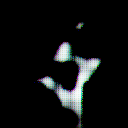

BATCH_SIZE 256
Gen loss: 2.3324244
Disc loss: 0.68414706
Disc accuracy: 0.8203125


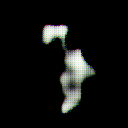

BATCH_SIZE 256
Gen loss: 2.775174
Disc loss: 0.52239037
Disc accuracy: 0.90234375


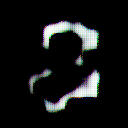

BATCH_SIZE 256
Gen loss: 2.5441663
Disc loss: 0.59505033
Disc accuracy: 0.921875


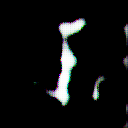

BATCH_SIZE 16
Gen loss: 2.4932506
Disc loss: 0.23904242
Disc accuracy: 0.9375


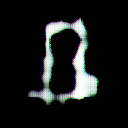


Epoch: 9
BATCH_SIZE 256
Gen loss: 2.6461859
Disc loss: 0.5299071
Disc accuracy: 0.92578125


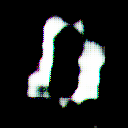

BATCH_SIZE 256
Gen loss: 2.975693
Disc loss: 0.63120955
Disc accuracy: 0.94140625


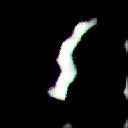

BATCH_SIZE 256
Gen loss: 1.9471403
Disc loss: 0.5761662
Disc accuracy: 0.83203125


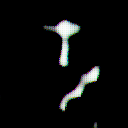

BATCH_SIZE 256
Gen loss: 2.2345448
Disc loss: 0.5091522
Disc accuracy: 0.890625


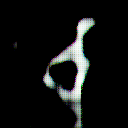

BATCH_SIZE 256
Gen loss: 2.5750325
Disc loss: 0.54549885
Disc accuracy: 0.91796875


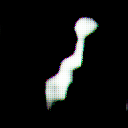

BATCH_SIZE 256
Gen loss: 3.1043038
Disc loss: 0.50580055
Disc accuracy: 0.9765625


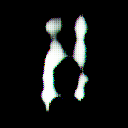

BATCH_SIZE 256
Gen loss: 2.297291
Disc loss: 0.47851828
Disc accuracy: 0.9140625


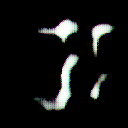

BATCH_SIZE 256
Gen loss: 2.3249474
Disc loss: 0.4406605
Disc accuracy: 0.88671875


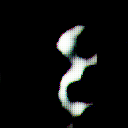

BATCH_SIZE 256
Gen loss: 2.733996
Disc loss: 0.35140282
Disc accuracy: 0.9375


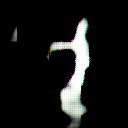

BATCH_SIZE 256
Gen loss: 3.5553293
Disc loss: 0.38669497
Disc accuracy: 0.99609375


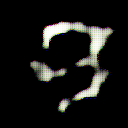

BATCH_SIZE 256
Gen loss: 2.8662953
Disc loss: 0.3659304
Disc accuracy: 0.9453125


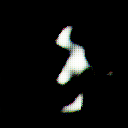

BATCH_SIZE 256
Gen loss: 1.9811639
Disc loss: 0.46261066
Disc accuracy: 0.81640625


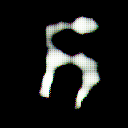

BATCH_SIZE 256
Gen loss: 3.7428508
Disc loss: 0.2892943
Disc accuracy: 0.99609375


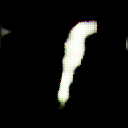

BATCH_SIZE 256
Gen loss: 3.95859
Disc loss: 0.40209714
Disc accuracy: 0.9921875


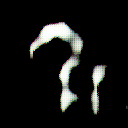

BATCH_SIZE 256
Gen loss: 2.657357
Disc loss: 0.3580105
Disc accuracy: 0.91796875


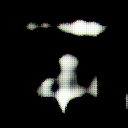

BATCH_SIZE 256
Gen loss: 2.1853926
Disc loss: 0.398256
Disc accuracy: 0.86328125


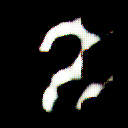

BATCH_SIZE 256
Gen loss: 4.0197835
Disc loss: 0.28540197
Disc accuracy: 0.99609375


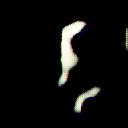

BATCH_SIZE 256
Gen loss: 4.2101536
Disc loss: 0.28009102
Disc accuracy: 1.0


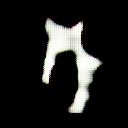

BATCH_SIZE 256
Gen loss: 2.993551
Disc loss: 0.26194513
Disc accuracy: 0.94140625


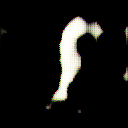

BATCH_SIZE 256
Gen loss: 2.5356345
Disc loss: 0.39021626
Disc accuracy: 0.8671875


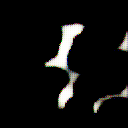

BATCH_SIZE 256
Gen loss: 4.0909944
Disc loss: 0.26667613
Disc accuracy: 0.96484375


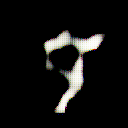

BATCH_SIZE 256
Gen loss: 4.552845
Disc loss: 0.39435136
Disc accuracy: 0.98828125


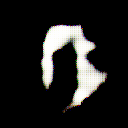

BATCH_SIZE 256
Gen loss: 2.8355517
Disc loss: 0.32853675
Disc accuracy: 0.91015625


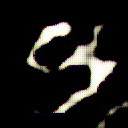

BATCH_SIZE 256
Gen loss: 2.269865
Disc loss: 0.56206584
Disc accuracy: 0.765625


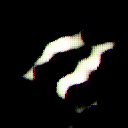

BATCH_SIZE 256
Gen loss: 5.0481358
Disc loss: 0.7068533
Disc accuracy: 1.0


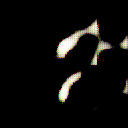

BATCH_SIZE 256
Gen loss: 3.5914364
Disc loss: 0.37955308
Disc accuracy: 0.96484375


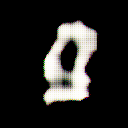

BATCH_SIZE 256
Gen loss: 1.7439673
Disc loss: 0.7694096
Disc accuracy: 0.7109375


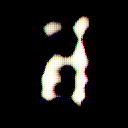

BATCH_SIZE 256
Gen loss: 3.5772333
Disc loss: 0.45288393
Disc accuracy: 0.94921875


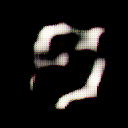

BATCH_SIZE 256
Gen loss: 4.0890536
Disc loss: 0.89788336
Disc accuracy: 0.953125


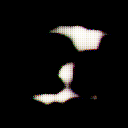

BATCH_SIZE 256
Gen loss: 1.9564207
Disc loss: 0.814229
Disc accuracy: 0.69921875


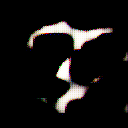

BATCH_SIZE 256
Gen loss: 2.2657766
Disc loss: 0.65809137
Disc accuracy: 0.8203125


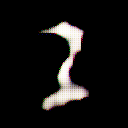

BATCH_SIZE 256
Gen loss: 3.2401054
Disc loss: 0.8992289
Disc accuracy: 0.92578125


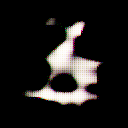

BATCH_SIZE 256
Gen loss: 2.8702445
Disc loss: 0.70598316
Disc accuracy: 0.92578125


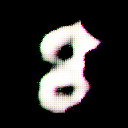

BATCH_SIZE 256
Gen loss: 1.6078466
Disc loss: 0.93572587
Disc accuracy: 0.69921875


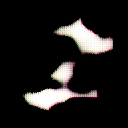

BATCH_SIZE 256
Gen loss: 2.4046066
Disc loss: 0.71773267
Disc accuracy: 0.84765625


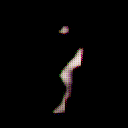

BATCH_SIZE 256
Gen loss: 2.955649
Disc loss: 0.9951854
Disc accuracy: 0.90625


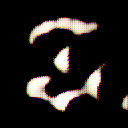

BATCH_SIZE 256
Gen loss: 2.2479615
Disc loss: 0.87276864
Disc accuracy: 0.8125


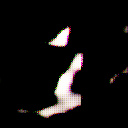

BATCH_SIZE 256
Gen loss: 1.6787715
Disc loss: 0.9506652
Disc accuracy: 0.71484375


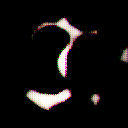

BATCH_SIZE 256
Gen loss: 2.1471815
Disc loss: 0.87857306
Disc accuracy: 0.83984375


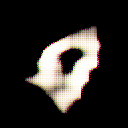

BATCH_SIZE 16
Gen loss: 2.3834784
Disc loss: 0.9328218
Disc accuracy: 0.8125


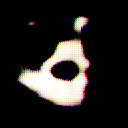

In [ ]:
#print(np.zeros_like(resized).ndim)
#print(train_dataset.batch(batch_size))
train(train_dataset, np.zeros((10000, 10)), 10)